# **Airbnb**

Airbnb es un mercado en línea y servicio de hospitalidad, que permite a las personas arrendar o alquilar alojamiento a corto plazo. Para que Airbnb brinde una experiencia personalizada a sus clientes, busca explorar la posibilidad de predecir el país de destino en el que un usuario realizará una reserva. Con esta información, Airbnb puede crear contenido más personalizado con su comunidad, disminuir el tiempo promedio para la primera reserva y mejorar la previsión de la demanda. Estos objetivos proporcionan beneficios mutuos para Airbnb y sus clientes: las recomendaciones personales pueden mejorar el compromiso de los clientes con la plataforma, lo que fomenta las reservas repetidas y las referencias a Airbnb para aquellos los amigos cercanos y familiares. En este ejercicio tenemos los datos de los clientes de Airbnb y se busca predecir el primer destino de reserva para los nuevos clientes de Airbnb que viajan desde los Estados Unidos. La variable de respuesta es el destino donde se realiza la reserva.

# Predicción de destinos de Airbnb


Este notebook demuestra todo el proceso de construcción de un modelo predictivo para sugerir el primer destino de los nuevos usuarios de Airbnb. Todos los procesos involucrados, tales como la ordenación de datos, el análisis exploratorio de datos, las estadísticas inferenciales y el aprendizaje automático, se han dividido en secciones principales.

**CONJUNTO DE DATOS**

Para este ejercicio se contara con el siguiente conjuntos de datos:

Una lista de usuarios junto con sus datos demográficos. Registros de sesiones web y algunas estadísticas de resumen. Debemos predecir en qué país será el primer destino de la reserva de un nuevo usuario. Todos los usuarios en el conjunto de datos son de los Estados Unidos.

Hay 12 resultados posibles del país de destino: ' US ',' FR ',' CA ',' GB ',' ES ',' IT ',' PT ',' NL ',' DE ',' AU ', 'NDF' (no se encontró destino), y 'otro'. 'otro' significa que hubo una reserva, pero es para un país que no está incluido en la lista, mientras que 'NDF' significa que no había una reserva.

Los conjuntos de entrenamiento y prueba están divididos por fechas. El conjunto de pruebas contiene nuevos usuarios con primeras actividades después del 07/01/2014. En el conjunto de datos de las sesiones, los datos solo se remontan al 01/01/2014, mientras que el conjunto de datos de los usuarios se remonta a 2010.

## Preprocesamiento de Datos
En este paso vamos a limpiar los datos. 
Todo el Preprocesamiento de datos se realizará utilizando la biblioteca de Python Pandas.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

El primer paso es cargar todos los datos disponibles para nosotros en un Pandas Dataframe y extraer información básica como el número de muestras, el número de filas de valores nulos, el número de funciones, etc. 
El siguiente paso sería tratar los valores faltantes usando un método adecuado (eliminación, interpolación, etc.) y convertir ciertas características en una forma más adecuada para aplicar estadísticas inferenciales y machine learning algorithms.

### Estadística de edad, género y población


In [2]:
df_agb = pd.read_csv('../input/age_gender_bkts.csv')
df_agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [3]:
df_agb.isnull().values.any()

False

Este Dataset no tiene valores nulos entre sus características.

Como primer paso, tratemos el dato de la edad. Las edades se indican en bloques de tamaño 5. Convertiremos esto en un valor numérico para que podamos aumentar su versatilidad si fuera necesario (es decir, se puede usar tanto como una característica categórica como continua). Como el tamaño del bloque es razonablemente pequeño, podemos definir una nueva función, **mean_age** que puede representar edades sin demasiada pérdida de información. El campo **mean_age** será el promedio del rango superior e inferior para ese bloque en particular.

In [4]:
#Convert 100+ into a bin.
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)
#Define mean_age feature
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [5]:
df_agb['country_destination'].value_counts()

CA    42
GB    42
IT    42
US    42
DE    42
NL    42
FR    42
ES    42
AU    42
PT    42
Name: country_destination, dtype: int64

El número de países es extremadamente pequeño. Probablemente corresponda a las clases por país disponibles en el conjunto de datos de capacitación que cubriremos más adelante en esta sección.

In [6]:
df_agb['gender'].value_counts()

male      210
female    210
Name: gender, dtype: int64

El género también se puede convertir en una variable binaria categórica. Representemos ** hombres con 0 y mujeres con 1. ** De nuevo, hacemos esto en caso de que necesitemos que esta variable funcione como una cantidad numérica. Debe indicarse que no hay una necesidad inmediata de ello y, por lo tanto, se puede omitir.

In [7]:
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_agb['gender'].value_counts()

1    210
0    210
Name: gender, dtype: int64

In [8]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

Solo hay un valor disponible para la característica del año. Por lo tanto, no tiene sentido mantener esta función, ya que no agrega ninguna información sobre los datos disponibles para nosotros. Dejaremos caer esta característica.

In [9]:
df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


### Estadisticas de País

In [10]:
df_con = pd.read_csv('../input/countries.csv')
df_con

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


Como tal, no necesitamos realizar ninguna limpieza para este conjunto de datos. Las estadísticas que se proporcionan aquí deberán incorporarse a nuestros conjuntos de datos de capacitación y pruebas antes de capacitar a nuestro modelo y/o se tendrán que utilizar en el análisis de datos exploratorios para obtener información adicional.

### Sesiones


In [11]:
df_ses = pd.read_csv('../input/sessions.csv')
df_ses.head(15)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [12]:
df_ses.shape

(10567737, 6)

Reemplazaremos los valores desconocidos con NaN para darle algún significado semántico esto dara lugar a mejores predicciones.

In [13]:
df_ses['action'] = df_ses['action'].replace('-unknown-', np.nan)
df_ses['action_type'] = df_ses['action_type'].replace('-unknown-', np.nan)
df_ses['action_detail'] = df_ses['action_detail'].replace('-unknown-', np.nan)

Primero, revisemos la variable secs_elapsed.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


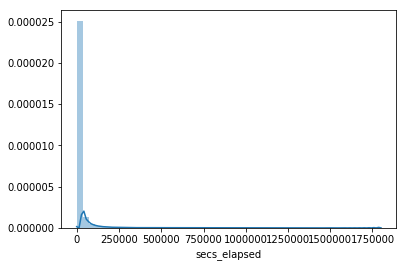

In [14]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

In [15]:
df_ses['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

El número promedio de segundos por sesión es ** 19450 segundos ** mientras que el valor de la mediana es ** 1147 segundos **. Esto sugiere un conjunto de datos muy sesgado con algunas observaciones atípicas que influyen en la media de la distribución.

In [16]:
len(df_ses[df_ses['secs_elapsed'].isnull()])

136031

Hay más de 136,000 campos para los cuales no sabemos el valor. Necesitamos descartar o interpolar estos valores. Por el momento, llenemos los valores no disponibles con la mediana de la distribución. Utilizamos la mediana ya que, como se mencionó anteriormente, esta distribución está fuertemente influenciada por valores atípicos.

In [17]:
median_secs = df_ses['secs_elapsed'].median()
df_ses['secs_elapsed'] = df_ses['secs_elapsed'].fillna(median_secs)

In [18]:
df_ses['secs_elapsed'].describe()

count    1.056774e+07
mean     1.917078e+04
std      8.833430e+04
min      0.000000e+00
25%      2.370000e+02
50%      1.147000e+03
75%      8.193000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

Como se puede ver anteriormente, la interpolación no ha alterado significativamente las estadísticas de resumen de la distribución. Esta es una buena opción para completar los valores nulos por el momento.

In [19]:
null_action = df_ses[(df_ses['action_type'].isnull()) | (df_ses['action_detail'].isnull()) | (df_ses['action'].isnull()) ]
null_action.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [20]:
null_action.shape

(2237000, 6)

In [21]:
len(null_action['action'].drop_duplicates())

270

Hay más de 2,23 millones de campos que tienen información incompleta sobre la acción, el tipo de acción o el detalle de la acción. Esto es aproximadamente el 20% de los datos que poseemos. Además, hay 270 tipos de acciones para las cuales tenemos valores nulos, por lo que examinarlos uno por uno simplemente no es posible de forma manual.

Dado que este no es nuestro conjunto de datos de entrenamiento, no descartaremos los valores. Lo mantendremos porque es posible extraer información incluso de filas que tienen columnas nulas.

In [22]:
df_ses[df_ses['device_type'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [23]:
df_ses['device_type'] = df_ses['device_type'].replace('-unknown-', np.nan)

In [24]:
df_ses['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

Como se puede ver arriba, hay 13 tipos de dispositivos que las personas están usando. También hay cierta actividad para la cual no tenemos datos sobre el dispositivo. Veamos cuántas instancias tiene esa cuenta.

In [25]:
len(df_ses[df_ses['device_type'].isnull()])

211279

Al igual que con las variables de acción, no descartaremos estos valores, ya que este no es el conjunto de datos al que aplicaremos nuestros algoritmos de aprendizaje automático. Sin embargo, reemplazaremos las cadenas desconocidas con NaN para darle un significado más semántico que podría ser útil en nuestro análisis.

### Usuarios de Entrenamiento

Ahora exploremos el conjunto de datos de entrenamiento que consiste en nuestros usuarios para quienes necesitamos predecir el primer destino.

In [26]:
df_train = pd.read_csv('../input/train_users_2.csv')
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [27]:
df_train.shape

(213451, 16)

In [28]:
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [29]:
df_train[df_train['first_device_type'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination


Las siguientes características en el conjunto de datos no tienen valores nulos:

1. date_account_created
2. timestamp_first_active
3. signup_method
4. signup_flow
5. language
6. affiliate_channel
7. affiliate_provider
8. signup_app
9. first_device_type

Las siguientes características en el conjunto de datos tienen valores nulos:

1. date_first_booking
2. gender
3. age
4. first_affiliate_tracked
5. first_browser

In [30]:
df_train[df_train['age'] > 120].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,NaN,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


Notamos que hay muestras para las cuales la edad es mucho mayor que 120 (la persona mayor tiene actualmente 114 años). Se trata de datos claramente contaminados y deben ser eliminados. Reemplazemos estos valores con NaN para indicar que no conocemos la edad real de estas personas.

In [31]:
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 120 else x)

## Estadística inferencial

### Preferencia de género para las reservaciones de Airbnb


En esta sección, aplicaremos herramientas estadísticas para obtener algunas inferencias e ideas sobre el tipo de datos con los que estamos tratando y cómo eliminar las relaciones entre varias características de nuestro conjunto de datos.

Para comenzar, verifiquemos si hay una preferencia basada en el género para ciertos países. En otras palabras, ¿el género de una persona afecta al primer país en el que reserva un Airbnb? Para responder a esta pregunta tendremos que probar la relación entre dos variables categóricas: Género y País de destino. Dado que el número de países de destino es multivariado, la ** Prueba de Significación  de Chi Cuadrada**.

Antes de comenzar, haremos ciertas suposiciones:
* Consideraremos solo a aquellos usuarios que hayan reclutado su género como hombres o mujeres. Desconocidos y otros géneros no se incluyen en este análisis.

* No consideramos a los usuarios que nunca han reservado un Airbnb o que han reservado en un país que no está inscrito como clase (NDF y Otro).

In [32]:
df_inf = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_inf = df_inf[['id', 'gender', 'country_destination']]
df_inf.head()

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US


In [33]:
df_inf['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [34]:
df_inf['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

#### Prueba de hipótesis

Para la prueba de hipótesis, definimos lo siguiente:

* ** Hipótesis nula: ** No existe una relación entre la preferencia del país y el sexo del cliente.
* ** Hipótesis alternativa: ** Existe una relación entre la preferencia del país y el sexo del cliente.

Asumiremos que nuestro nivel de significación, $ \ alpha $ sea 0.05.

In [35]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
del observed.columns.name
observed = observed.set_index('gender')
observed

,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [36]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [37]:
chi2

116.87183139602567

In [38]:
p

5.830126955071572e-21

El p-value que hemos obtenido es menor que nuestro nivel de significación elegido. Por lo tanto, rechazamos la hipótesis nula y aceptamos la hipótesis de alteración negativa. ** Existe una relación entre la preferencia de país y el sexo del cliente. ** Esta información puede ser extremadamente útil para nosotros cuando realizamos ingeniería de características en pasos posteriores.


### Preferencias de registro


En esta sección, trataremos de descubrir una relación entre el método de registro y el dispositivo de registro. Una consulta preliminar de nuestro marco de datos nos dice que la mayoría de los usuarios se registran a través del método básico estándar o de Facebook. Además, inician sesión utilizando un navegador de escritorio, un navegador móvil o una aplicación móvil.

¿El tipo de dispositivo (móvil o computadora) afecta el método de registro en Airbnb? Intentaremos responder a esta pregunta aquí. Una vez más, como antes, haremos ciertas suposiciones.
* Ignoraremos el método de registro de Google ya que hay muy pocas instancias de él.
* Consideraremos que iOs, Moweb y Android son del tipo de dispositivo móvil.

In [39]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


In [40]:
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [41]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

#### Prueba de hipótesis

Vamos a configurar ahora nuestra prueba de hipótesis. Definiremos lo siguiente:

* ** Hipótesis nula: ** No existe una relación entre el tipo de dispositivo y el método de registro.
* ** Hipótesis alternativa: ** Existe una relación entre el tipo de dispositivo y el método de registro.

Suponga que el nivel de significación $ \ alpha $ está en 0.05.

Realizaremos la misma prueba de hipótesis utilizando dos herramientas estadísticas diferentes: la prueba de significación de Chi cuadrado y la prueba de estadística Z. Si se realiza correctamente, ambas pruebas deben darnos los mismos resultados.

In [42]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


#### Prueba Chi Cuadrado

In [43]:
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [44]:
chi2

0.07183824273421707

In [45]:
p

0.7886788661023779

El p-value obtenido es más alto que nuestro nivel de significación elegido. Por lo tanto, no estamos en posición de rechazar la hipótesis nula. Se destaca. ** No existe una relación entre el tipo de dispositivo y el método de registro. ** Realicemos la misma prueba de hipótesis utilizando la Prueba Z y comparemos los resultados y el p-value obtenido.

#### Prueba de significancia de dos muestras

Ahora hagamos la misma prueba de hipótesis utilizando la prueba de significación de dos muestras para proporciones.

In [46]:
df_signup.loc['Total'] = [ df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [47]:
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook']
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2)
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.3491674188640724)

In [48]:
basic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']
basic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - basic_prop) ** 2) + df_signup.loc['Computer', 'Basic'] * ((0 - basic_prop) ** 2)
basic_std = np.sqrt(basic_std/df_signup.loc['Total', 'Basic'])

basic_prop, basic_std

(0.14166399602346677, 0.34870518816635054)

In [49]:
h0_prop = 0

prop_diff = fb_prop - basic_prop
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic'] + df_signup.loc['Total', 'Facebook']) 
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])
sigma_diff = np.sqrt(var_diff)

prop_diff, sigma_diff

(0.0004503887252333971, 0.001680388342245922)

In [50]:
z = (prop_diff - h0_prop) / sigma_diff
z

0.2680265709481359

In [51]:
p = (1-stats.norm.cdf(z))*2
p

0.7886788661023794

El p-value obtenido es más alto que nuestro nivel de significancia elegido. Por lo tanto, no estamos en posición de rechazar la hipótesis nula. Se destaca. ** No existe una relación entre el tipo de dispositivo y el método de registro. **

También tenga en cuenta que los p-value obtenidos para la Prueba de Significación de Dos Muestras y la Prueba de Significación de Chi Cuadrado (sin corrección) son ** exactamente iguales. ** Ahora estamos en condiciones de resumir y presentar nuestros resultados en función del análisis estadístico realizado.

### Conclusiones

* Hay ** una relación ** entre género y Airbnb Country Destination. En otras palabras, el género influye en el país de su elección.
* No hay ** relación ** entre el tipo de dispositivo y el método de registro. Las dos variables son independientes entre sí.
* Los resultados obtenidos de la Prueba de Significación de Chi Cuadrado y la Prueba de Significación de Dos Muestras son ** exactamente los mismos **.

## Análisis exploratorio de datos

En esta sección, intentaremos visualizar y resumir nuestros datos para extraer nuevos conocimientos sobre las características individuales y la relación que comparten con las otras características. Primero intentemos y visualicemos las estadísticas de edad y género de varios países.



### Estadísticas de País

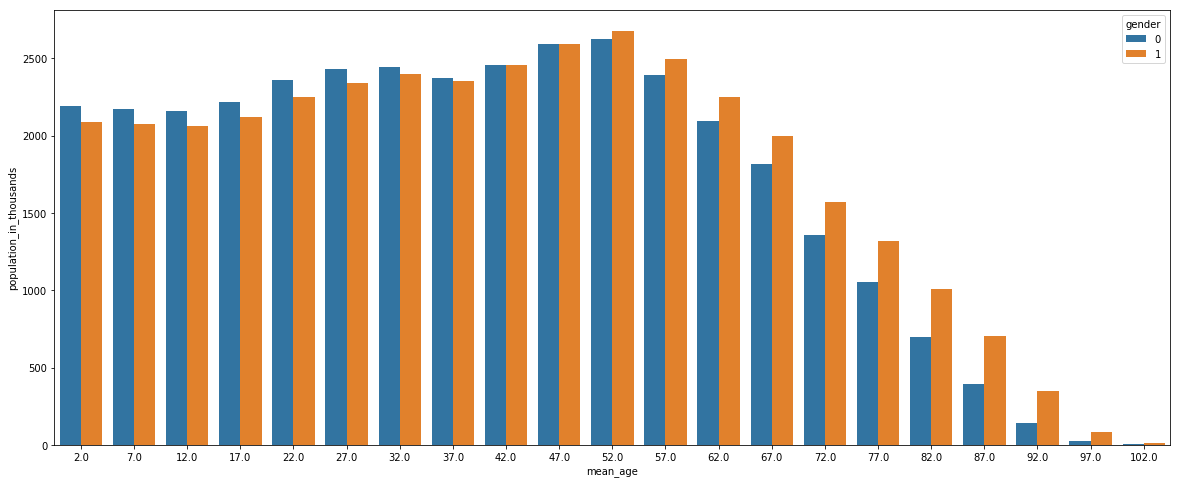

In [52]:
plt.figure(figsize=(20,8))
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, ci=None)

**#### Observaciones

* Los países que están representados en esta estadística consisten en gran parte de un ** envejecimiento de la población **. Los grupos más grandes son personas con ** edad media de 47 años y 52 años **.
* La distribución se asemeja a una curva de campana sesgada. Las personas de mediana edad ocupan la mayor parte de la población, seguidas de cerca por los jóvenes y, finalmente, por los ancianos.
* Los conteos poblacionales de personas jóvenes y de mediana edad son bastante comparables. Pero a medida que hacemos la transición hacia la vejez (edad> 57 años), el conteo de la población para cada grupo sucesivo disminuye constantemente.
* Una cosa muy interesante a tener en cuenta (aunque puede no ser relevante para nuestro análisis) es que la proporción de sexos se inclina hacia los hombres para los grupos de edad más jóvenes, pero a medida que aumenta la edad media, la proporción se inclina más hacia las mujeres. ** Las mujeres de hecho viven más que los hombres. **

A continuación, tratemos de graficar el conteo de la población en cada país.

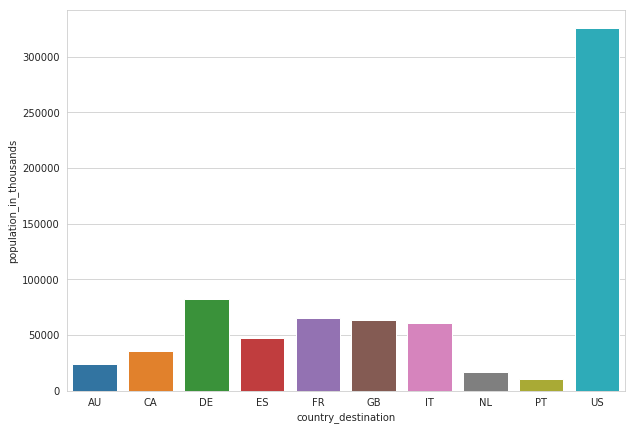

In [53]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
pop_stats = df_agb.groupby('country_destination')['population_in_thousands'].sum()
sns.barplot(x=pop_stats.index, y=pop_stats)

** Los Estados Unidos de América ** son claramente la nación más poblada entre los países de destino con una población de más de ** 300 millones **. Todos los demás países de la lista tienen una población ** inferior a 100 millones. **

A continuación, vamos a crear un gráfico de barras de la distancia del país desde el país de origen (Estados Unidos de América). Luego, construiremos un diagrama de dispersión entre la frecuencia de reserva en un país y la distancia del país. Mi intuición inicial es que cuanto más lejos esté un país, menos probabilidades habrá de que la gente visite ese país en particular. Debe haber al menos una pequeña correlación megativa entre estas dos cantidades.

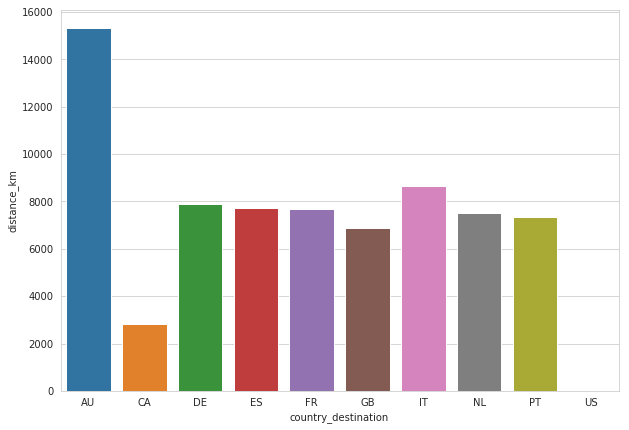

In [54]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='country_destination', y='distance_km', data=df_con)

In [55]:
country_popularity = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other')]['country_destination'].value_counts()

In [56]:
country_distance = pd.Series(df_con['distance_km'])
country_distance.index = df_con['country_destination']

In [57]:
language_distance = pd.Series(df_con['language_levenshtein_distance'])
language_distance.index = df_con['country_destination']

In [58]:
country_area = pd.Series(df_con['destination_km2'])
country_area.index = df_con['country_destination']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


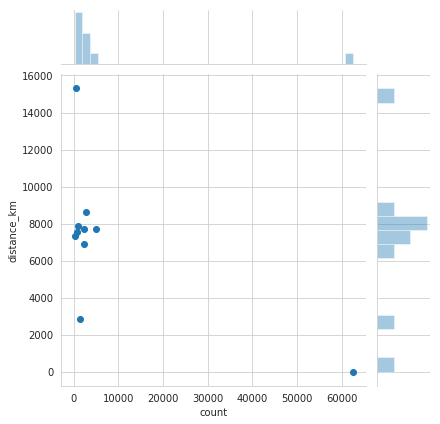

In [59]:
df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp)

Hay una ** fuerte correlación negativa de -0.65. ** La gente prefiere abrumadoramente reservar en los Estados Unidos que cualquier otro país del mundo. Podemos atribuir esta preferencia a la distancia. Verifiquemos si esto también es válido para los países internacionales.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


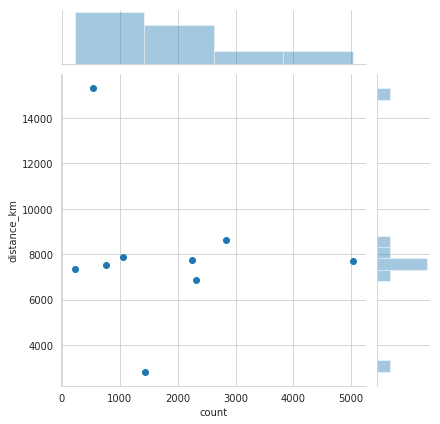

In [60]:
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))

La correlación, con Estados Unidos fuera de la ecuación, ** es mucho menor en -0.18. ** Sin embargo, todavía hay una correlación negativa entre las dos cantidades.

A continuación, verifiquemos si el idioma que se habla en un país en particular influye en el número de reservas en ese país. Para calcular esta métrica, utilizaremos el ** Idioma Levenshtein Distance ** del idioma oficial de cada país desde el inglés. Estos datos ya están disponibles para nosotros por Airbnb. Una vez más, al igual que la distancia física, mi conjetura es que a menor distancia de levenshtein, mayor es el número de reservas en ese país.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


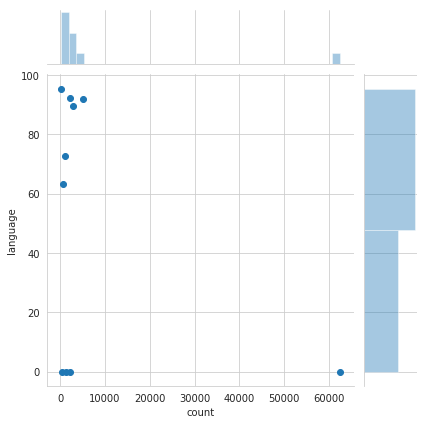

In [61]:
sns.jointplot(x='count', y='language', data=df_dp)

Parece que hay una ** correlación media negativa de -0.38 ** entre las dos cantidades. Esto sugiere que las personas prefieren los países que hablan inglés. ¿Pero es ese el caso realmente? Eliminemos una vez más Estados Unidos, el país de origen y recalcularemos nuestro coeficiente de correlación.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


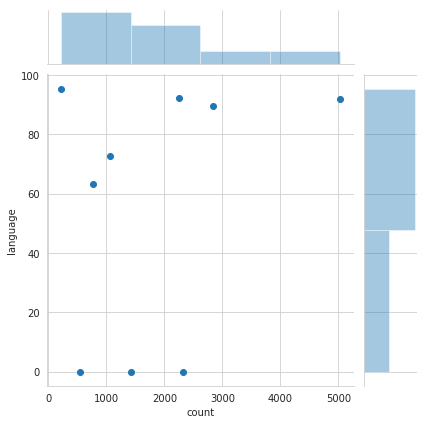

In [62]:
sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

El resultado de esta visualización es extremadamente interesante.

* Vemos que cuando se elimina a Estados Unidos de la lista de países, en realidad existe ** una correlación positiva ** entre la distancia de idioma y la frecuencia de reserva.
* A primera vista, esto puede sugerir que las personas prefieren países con diferentes idiomas (y, por lo tanto, cultura) cuando viajan al extranjero.
* Otra forma de verlo sería que ** Europa es un destino de viaje muy popular para los estadounidenses ** y tienden a preferirlo a otros países de habla inglesa como Canadá y Australia. Entonces, esto puede no tener nada que ver con la diferencia de idioma, ya que puede tener que ver con la preferencia de destino.

Finalmente, en esta sección, verifiquemos si el tamaño del país tiene algo que ver con la preferencia de reserva. Al igual que en los dos casos anteriores, tenemos datos sobre el tamaño de cada país.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


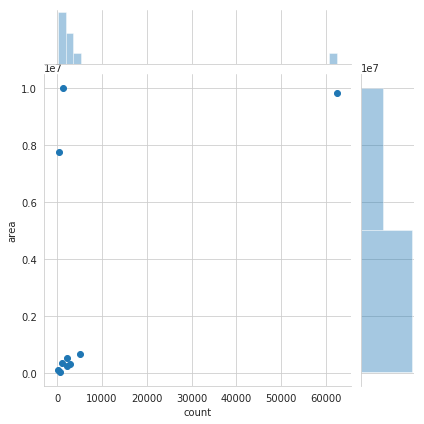

In [63]:
sns.jointplot(x='count', y='area', data=df_dp)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


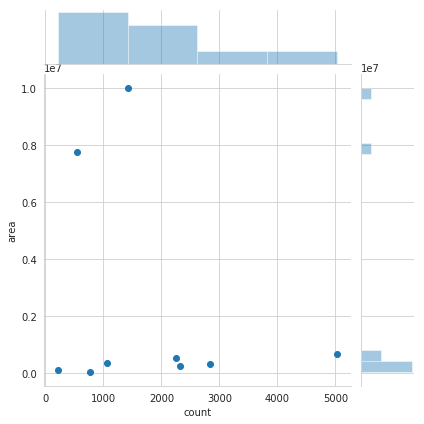

In [64]:
sns.jointplot(x='count', y='area', data=df_dp.drop('US'))

Los resultados con el área se asemejan mucho a lo que hemos obtenido de nuestras pruebas de distancia de idioma. En general, existe una correlación positiva entre el tamaño del país y la preferencia de reserva. Esto se debe principalmente a que Estados Unidos es un país grande (el segundo más grande en esta lista).

Sin embargo, cuando se eliminan los EE. UU., Los datos ** muestran una correlación negativa. ** Nuevamente, como en el caso del idioma, esto puede no tener nada que ver con el tamaño del país sino con la preferencia de destino. Los países europeos son generalmente pequeños en tamaño pero extremadamente populares entre los turistas estadounidenses.

### Estadísticas de Sesión

En esta sección, trataremos de visualizar algunas de las estadísticas de sesión que se nos dieron. Primero, como ya lo hemos hecho antes, representemos la distribución de la cantidad de tiempo que los usuarios dedicaron a cada sesión.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


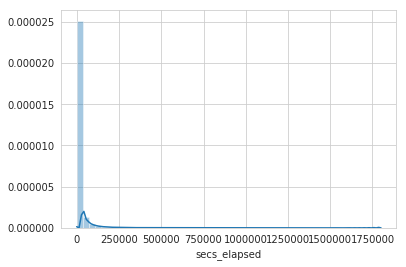

In [65]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

Parece que casi todas las sesiones duraron menos de 5000 segundos. Echemos un vistazo más profundo en estas sesiones.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


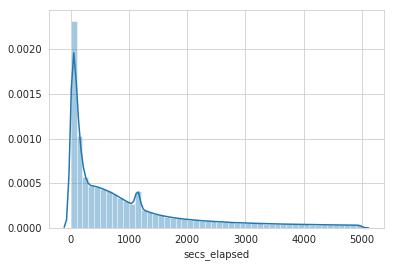

In [66]:
sns.distplot(df_ses[(df_ses['secs_elapsed'].notnull()) & (df_ses['secs_elapsed'] < 5000)]['secs_elapsed'])

Podemos ver que la mayoría del número de sesiones de más de 1000 segundos disminuye casi exponencialmente. Es justo suponer que la mayoría de las sesiones duraron menos de 1000 segundos. Para verificar esto, veamos su participación en el número total de sesiones.

In [67]:
len(df_ses[df_ses['secs_elapsed'] < 1000])/len(df_ses[df_ses['secs_elapsed'].notnull()])

0.4672638049186879

** Casi el 47% de todas las sesiones duraron menos de 1000 segundos. ** Esto sugiere fuertemente una distribución exponencial decreciente de los segundos transcurridos en cada sesión. En otras palabras, a medida que aumenta la cantidad de segundos, la cantidad de instancias de sesiones que requieren ese tiempo disminuye exponencialmente.

Finalmente, en esta sección, construiremos un diagrama de barras de todos los dispositivos utilizados por varios usuarios para interactuar con el sitio web y la aplicación de Airbnb.

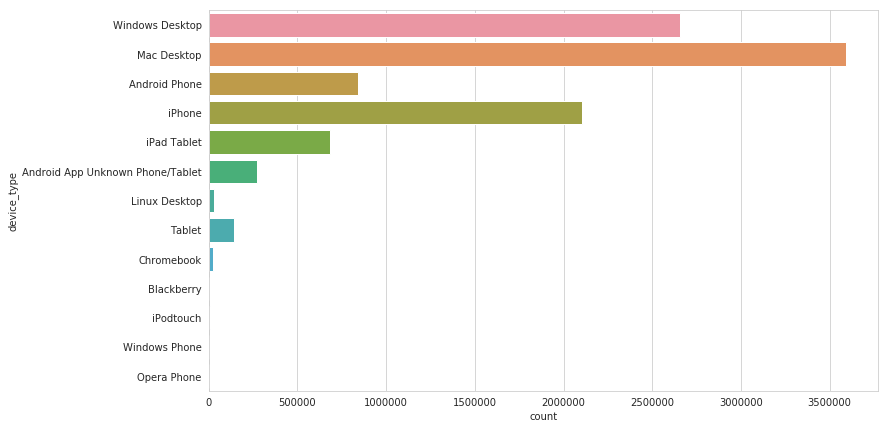

In [68]:
plt.figure(figsize=(12,7))
sns.countplot(y='device_type', data=df_ses)

El ** Mac Desktop ** es el dispositivo más popular entre los usuarios de Airbnb, seguido por el ** Windows Desktop. ** Un dato interesante es que ** los productos de Apple son extremadamente populares entre los usuarios de Airbnb. ** El iPhone, el iPad y el Todos los Mac aparecen en la lista de los 5 dispositivos más populares.

### Estadísticas de usuarios de entrenamiento

En esta sección, intentaremos obtener información sobre nuestro conjunto de datos principal: el conjunto de datos de capacitación. Estas ideas se aplicarán directamente en los pasos posteriores de la ingeniería de características y el aprendizaje automático.

El primer paso es trazar la frecuencia de cada clase.

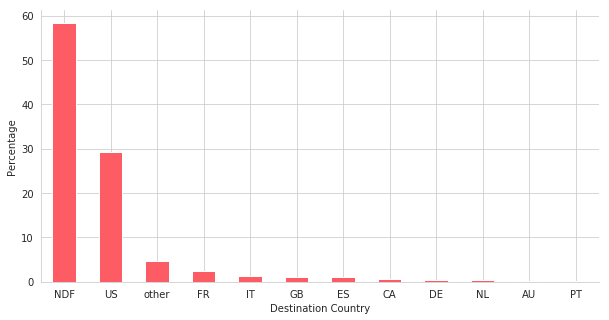

In [69]:
plt.figure(figsize=(10,5))
country_share = df_train['country_destination'].value_counts() / df_train.shape[0] * 100
country_share.plot(kind='bar',color='#FD5C64', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

Como se puede ver arriba, cerca del ** 60% de los usuarios nunca han reservado un Airbnb. ** Entre los usuarios que lo han hecho, han elegido abrumadoramente ** Estados Unidos como su primer destino. ** Al entrenar nuestro modelo de aprendizaje automático, Nos interesa separar a los bookers de los no bookers. La clasificación subsiguiente entre los bookers daría una gran precisión, ya que podríamos usar el desequilibrio de clases a nuestro favor.

Como se puede ver arriba, cerca del ** 60% de los usuarios nunca han reservado un Airbnb. ** Entre los usuarios que lo han hecho, han elegido abrumadoramente ** Estados Unidos como su primer destino. ** Al entrenar nuestro modelo de aprendizaje automático, Nos interesa separar a los bookers de los no bookers. La clasificación subsiguiente entre los bookers daría una gran precisión, ya que podríamos usar el desequilibrio de clases a nuestro favor.

In [70]:
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

#### La visualización de barras apiladas

El gráfico de barras apiladas será la principal herramienta de visualización en la EDA. La idea se tomó de la excelente libreta de notas de kevinwu06 sobre el análisis exploratorio de Airbnb.

El gráfico de barras apiladas nos proporciona una colección de barras de colores proporcionales donde cada color representa una clase (o el destino). Como hay más de 10 clases, elegí renunciar a la leyenda. Los colores que nos interesan son ** azul oscuro (barra inferior) que corresponde a la clase NDF ** y ** azul (segunda barra inferior) que corresponde a la clase US **. Como ya hemos visto, estas dos clases forman la mayoría y, por lo tanto, ocuparán la mayor parte del área de cada barra. Cada barra ha sido normalizada con respecto a su tamaño.

Lo que intentaremos deducir es la proporción de la barra que pertenece a la clase de no reserva (azul oscuro). Si es grande, significa que es poco probable que un segmento en particular reserve un Airbnb. Si son pequeños, significa que están más inclinados a hacerlo.

In [71]:
def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

#### Género

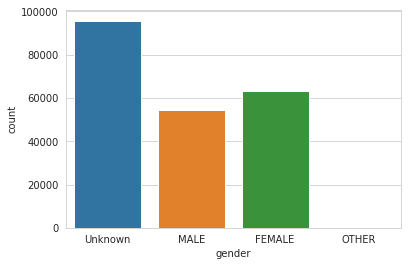

In [72]:
sns.countplot(df_train['gender'].fillna('Unknown'))

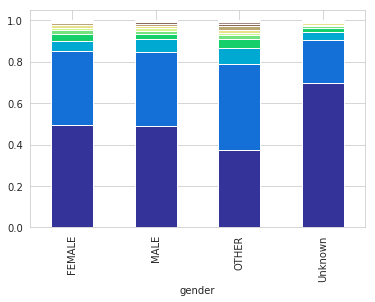

In [73]:
stacked_bar('gender')

Vemos que los usuarios cuyo género es desconocido forman la mayoría. De los usuarios cuyo sexo se conoce, ** hay más mujeres que hombres. ** Esto puede sugerir dos cosas:
1. Hay más usuarios femeninos de Airbnb que hombres
2. Las mujeres tienen más probabilidades de revelar su género que los hombres.

Un punto muy interesante a destacar es que ** las personas que no han marcado su género tienen menos probabilidades de reservar un Airbnb. ** Además, las personas que se han marcado a sí mismas como ** 'otras' son más probables ** que cualquier otro grupo para hacer una reserva. Esto podría no ser una idea muy potente ya que el otro grupo es una proporción insignificante de la población.

#### Edad

Estudiemos ahora las edades de los usuarios y tratemos de obtener información sobre ello. Como vimos en una sección anterior, no tenemos los datos de edad de una parte considerable de los usuarios. Intentemos trazar la distribución de los que hacemos.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


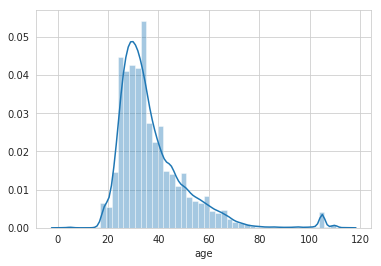

In [74]:
sns.distplot(df_train['age'].dropna())

¿Es más probable que algunos grupos de edad reserven en un destino en particular? Para responder a esta pregunta, usaremos el diagrama de caja y observaremos la distribución de edades de los viajeros a un país en particular.

(10, 75)

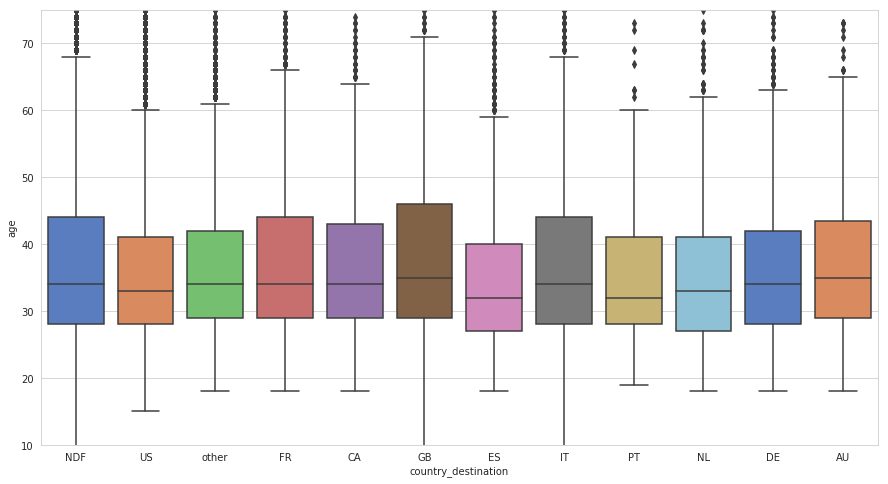

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax)
ax.set_ylim([10, 75])

Desde la gráfica de boxplot, encontramos que la distribución es más o menos la misma para cada país. ** Gran Bretaña ** tiene la edad media más alta de los viajeros y ** España ** es más popular entre los viajeros más jóvenes.

In [76]:
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

In [77]:
df_train['age_group'] = df_train['age'].apply(set_age_group)

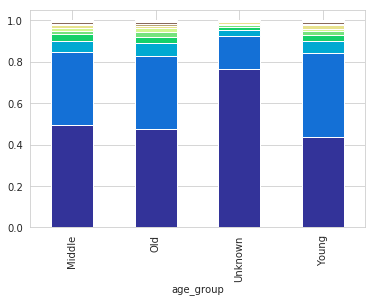

In [78]:
stacked_bar('age_group')

Definimos una nueva característica ** age_group ** para agrupar a nuestros usuarios en 4 grupos de edad:
* Las personas menores de 40 años son etiquetadas como jóvenes.
* Las personas con edades comprendidas entre 40 y 60 años son etiquetadas como de mediana edad.
* Las personas mayores de 60 años son etiquetadas como viejas.
* Las personas con edades desconocidas son etiquetadas como desconocidas.

Descubrimos que las personas que no han revelado su edad ** tienen menos probabilidades de reservar un Airbnb. ** De los usuarios cuya edad conocemos, ** las personas de mediana edad tienen más probabilidades de reservar un Airbnb. ** Aunque debe ser señaló que no hay una diferencia muy significativa entre los tres grupos.

#### Método de registro

En una sección anterior, ya establecimos que ** basic ** y ** Facebook ** eran los métodos de registro más populares. ** Google ** rara vez se usaba.

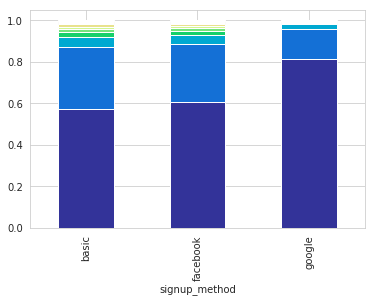

In [79]:
stacked_bar('signup_method')

Descubrimos que las personas que usan el método de registro ** básico ** tienen más probabilidades de reservar un Airbnb, mientras que las personas que usan ** google ** tienen menos probabilidades de hacer una reserva.

#### Idioma

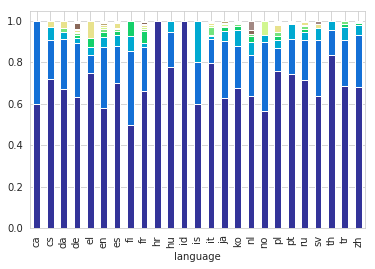

In [80]:
stacked_bar('language')

Vemos que las personas que hablan ** húngaro ** y ** indonesio ** casi no hacen reservas. Las personas que hablaron ** finlandés ** hicieron la mayoría de las reservas entre todos los idiomas. Sin embargo, dado que los usuarios son estadounidenses, podemos asumir con seguridad que los usuarios que no son ingleses constituyen una minoria.

#### Canales de afiliados y proveedores

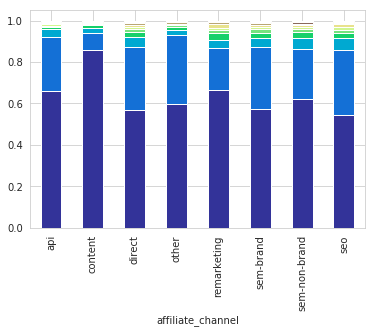

In [81]:
stacked_bar('affiliate_channel')

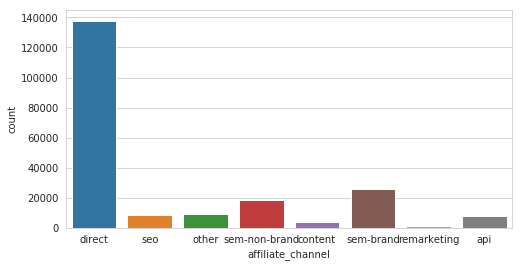

In [82]:
plt.figure(figsize=(8,4))
sns.countplot(df_train['affiliate_channel'])

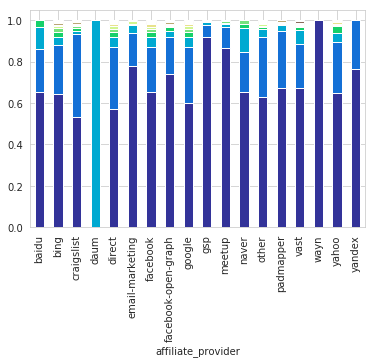

In [83]:
stacked_bar('affiliate_provider')

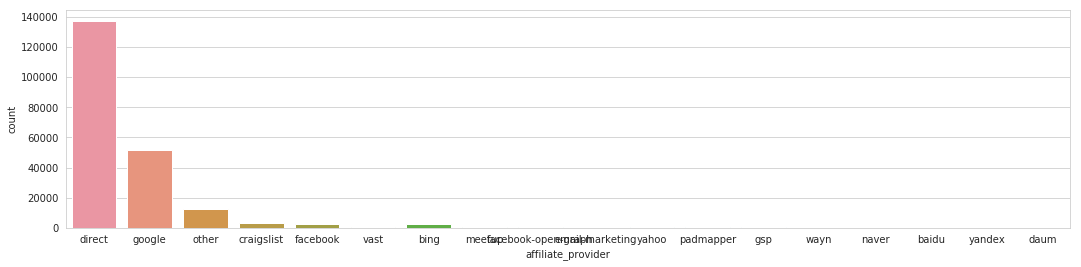

In [84]:
plt.figure(figsize=(18,4))
sns.countplot(df_train['affiliate_provider'])

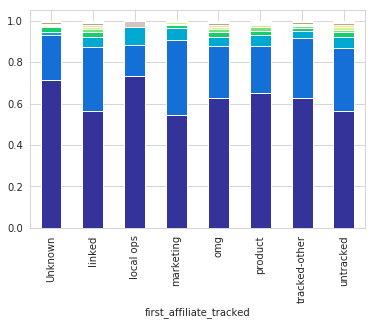

In [85]:
stacked_bar('first_affiliate_tracked')

Algunas observaciones de las visualizaciones anteriores:
* El ** Canal Directo ** tiene la mayor cantidad de conversiones a las reservas, mientras que el ** Canal de Contenido ** tiene la menor cantidad.
* ** Direct ** y ** Google ** son los proveedores afiliados más populares.
* ** Wayn ** tiene el menor porcentaje de conversiones mientras que ** Daum ** tiene el mayor porcentaje. Sin embargo, debemos tomar esto con una pizca de sal, ya que puede ser que el número de puntos de muestra de estas categorías sea extremadamente pequeño (como lo sugiere la gráfica de conteo).
* Aparte de lo anterior, ** Google ** y ** Craigslist ** tienen un buen porcentaje de conversiones.
* Las personas con ** Marketing ** afiliados eran más propensas a reservar. Las personas cuyo primer afiliado fue registrado como ** Operaciones locales ** o ** Desconocido ** fueron las menos probables.

#### Flujo de Inscripción

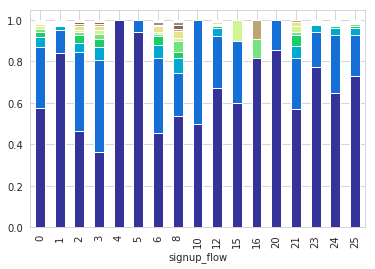

In [86]:
stacked_bar('signup_flow')

El gráfico de barras apiladas del flujo de inscripción genera observaciones muy interesantes: ** las personas con flujo de registro 3 ** tienen más probabilidades de reservar un Airbnb. Por el contrario, las personas con flujos de registro ** 4 y 5 tienen menos probabilidades de convertirse. **

#### Tipo de dispositivo, navegador y aplicación utilizados

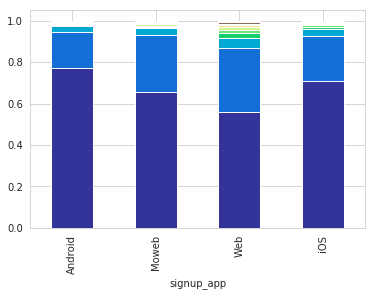

In [87]:
stacked_bar('signup_app')

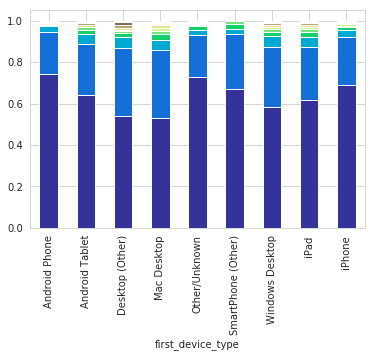

In [88]:
stacked_bar('first_device_type')

Como hay demasiados navegadores, lo ignoraremos por el momento e intentaremos reducir las categorías en un paso posterior. Por ahora, podemos hacer las siguientes observaciones sobre los dispositivos de usuario:
* Los usuarios que usan la aplicación web ** tienen más probabilidades de reservar un Airbnb, mientras que ** los usuarios de Android ** tienen menos probabilidades de hacerlo.
* ** Las personas con un teléfono Android o cuyos dispositivos eran desconocidos ** compraron menos Airbnbs. La gente en computadoras de escritorio (Mac o de otro tipo) compró más.

Esto sugiere fuertemente que los usuarios en su escritorio tendrán más probabilidades de reservar un Airbnb y los Usuarios de Apple son más propensos a comprar en el sitio web, mientras que los Usuarios de Android son los menos.

#### Fechas

Revisemos primero las tendencias acerca de cuándo se crearon las primeras cuentas.

In [89]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])

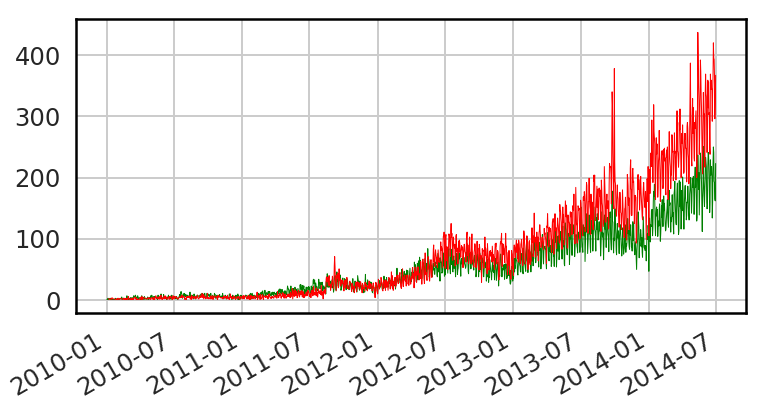

In [90]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

df_train[df_train['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
df_train[df_train['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

El número de usuarios que no reservan ha aumentado más que el número de usuarios que reservan a medida que pasa el tiempo. Esto se puede atribuir al hecho de que más personas están utilizando la plataforma solo para la exploración. Otra razón podría ser que dado que el usuario estuvo en la plataforma por un tiempo más prolongado, era más probable que él / ella siguiera adelante y reservara un espacio. Esto implica directamente que ** cuanto antes el usuario había creado una cuenta en Airbnb, era más probable que hiciera una reserva. **

Con todo esto en mente, no podemos continuar con el Paso de ingeniería de características. Las características que aún no hemos explorado en esta sección se explorarán en la siguiente.

## Ingeniería de características

Ahora, con todas estas visualizaciones e ideas en nuestro haber, procedamos a desarrollar algunas características nuevas que nos ayudarán a obtener mejores predicciones cuando finalmente capacitemos nuestro modelo de aprendizaje automático. Primero, me gustaría extraer características de nuestro conjunto de datos de sesiones. Además, dado que no hemos hecho demasiada visualización de nuestras sesiones, este sería un buen lugar para hacerlo.

In [91]:
df_ses.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


> ### Características de la sesión

La primera característica que quiero diseñar es la cantidad de dispositivos a los que un usuario accede a la aplicación. ** Mi corazonada es que si el usuario usa muchos dispositivos, implica que viaja muy a menudo y, por lo tanto, es probable que reserve un Airbnb. ** Una hipótesis adicional es que si la persona viaja mucho, s / probablemente debe ser un viajero de negocios y, por lo tanto, es probable que esté dispuesto a reservar Airbnbs dentro de los Estados Unidos.

La segunda característica que quiero es el ** número total de segundos que el usuario ha gastado en las sesiones de Airbnb. ** Será interesante ver cómo esto se correlaciona con nuestras clases.

La tercera característica es ** segundos promedio por sesión. ** Nuevamente, no tengo mucha intuición detrás de este paso, pero tengo la sensación de que esta característica puede ser útil.

La cuarta característica es ** el número total de sesiones. ** Al igual que con los segundos totales, esto podría indicar un mayor interés. Además, también construiremos una característica de ** número de tipos de sesión ** para cuantificar aún más el interés y el compromiso del usuario.

La última característica que quiero ver es ** número de sesiones cortas. ** Estas son sesiones de menos de 300 segundos de duración. Construiremos un ** número de sesiones largas ** al restarlo del número total de sesiones.

In [92]:
def session_features(df):
    df['total_seconds'] = df['id'].apply(lambda x: total_seconds[x] if x in total_seconds else 0)
    df['average_seconds'] = df['id'].apply(lambda x: average_seconds[x] if x in average_seconds else 0)
    df['total_sessions'] = df['id'].apply(lambda x: total_sessions[x] if x in total_sessions else 0)
    df['distinct_sessions'] = df['id'].apply(lambda x: distinct_sessions[x] if x in distinct_sessions else 0)
    df['num_short_sessions'] = df['id'].apply(lambda x: num_short_sessions[x] if x in num_short_sessions else 0)
    df['num_long_sessions'] = df['id'].apply(lambda x: num_long_sessions[x] if x in num_long_sessions else 0)
    df['num_devices'] = df['id'].apply(lambda x: num_devices[x] if x in num_devices else 0)
    return df

In [93]:
def browsers(df):
    df['first_browser'] = df['first_browser'].apply(lambda x: "Mobile_Safari" if x == "Mobile Safari" else x)
    major_browsers = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile_Safari']
    df['first_browser'] = df['first_browser'].apply(lambda x: 'Other' if x not in major_browsers else x)
    return df

In [94]:
def classify_device(x):
    if x.find('Desktop') != -1:
        return 'Desktop'
    elif x.find('Tablet') != -1 or x.find('iPad') != -1:
        return 'Tablet'
    elif x.find('Phone') != -1:
        return 'Phone'
    else:
        return 'Unknown'

In [95]:
def devices(df):
    df['first_device_type'] = df['first_device_type'].apply(classify_device)
    return df

In [96]:
def affiliate_tracked(df):
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('Unknown')
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].apply(lambda x: 'Other' if x != 'Unknown' and x != 'untracked' else x)
    return df

In [97]:
def affiliate_provider(df):
    df['affiliate_provider'] = df['affiliate_provider'].apply(lambda x: 'rest' if x not in ['direct', 'google', 'other'] else x)
    return df

In [98]:
def affiliate_channel(df):
    df['affiliate_channel'] = df['affiliate_channel'].apply(lambda x: 'other' if x  not in ['direct', 'content'] else x)
    return df

In [99]:
def languages(df):
    df['language'] = df['language'].apply(lambda x: 'foreign' if x != 'en' else x)
    return df

In [100]:
def first_booking(df):
    df = df.drop('date_first_booking', axis=1)
    return df

In [101]:
def account_created(df):
    df = df.drop('date_account_created', axis=1)
    return df

In [102]:
def feature_engineering(df):
    df = session_features(df)
    df = df.drop('age', axis=1)
    df = browsers(df)
    df =devices(df)
    df =affiliate_tracked(df)
    df = affiliate_provider(df)
    df = affiliate_channel(df)
    df = languages(df)
    df['is_3'] = df['signup_flow'].apply(lambda x: 1 if x==3 else 0)
    df = first_booking(df)
    df = df.drop('timestamp_first_active', axis=1)
    df = account_created(df)
    df = df.set_index('id')
    df = pd.get_dummies(df, prefix='is')
    return df

In [103]:
total_seconds = df_ses.groupby('user_id')['secs_elapsed'].sum()

In [104]:
average_seconds = df_ses.groupby('user_id')['secs_elapsed'].mean()

In [105]:
total_sessions = df_ses.groupby('user_id')['action'].count()

In [106]:
distinct_sessions = df_ses.groupby('user_id')['action'].nunique()

In [107]:
num_short_sessions = df_ses[df_ses['secs_elapsed'] <= 300].groupby('user_id')['action'].count()
num_long_sessions = df_ses[df_ses['secs_elapsed'] >= 2000].groupby('user_id')['action'].count()

In [108]:
num_devices = df_ses.groupby('user_id')['device_type'].nunique()

In [109]:
df_train = session_features(df_train)

Since we already have our age groups, we can drop the age feature.

In [110]:
df_train = df_train.drop('age', axis=1)

Hay más de 50 categorías de navegadores, aunque la mayoría utiliza solo 5. Por lo tanto, agruparemos todos los exploradores menores en la categoría 'Otros'.

Luego, de nuestra visualización anterior, vimos que los usuarios de computadoras de escritorio tenían más probabilidades de reservar Airbnbs, seguidos por los usuarios de Tabletas, usuarios de teléfonos y finalmente personas cuyos dispositivos eran desconocidos. Vamos a reducir first_device_type en estas categorías.

In [111]:
df_train = browsers(df_train)

In [112]:
df_train = devices(df_train)

Hagamos lo mismo con los afiliados.

In [113]:
df_train = affiliate_tracked(df_train)

In [114]:
df_train = affiliate_provider(df_train)

In [115]:
df_train = affiliate_channel(df_train)

El idioma utilizado es mayoritariamente el inglés. Por lo tanto, tiene sentido apilar a los demás.

In [116]:
df_train = languages(df_train)

En nuestra sección de EDA, notamos que las personas con flujo de registro 3 tuvieron un número desproporcionado de conversiones. Por lo tanto, definiremos una característica adicional que identifique a estos usuarios. También revertiremos nuestra fatiga de género al rellenar los NaN con Desconocido ya que deducimos que esto llevará a una mejora en la predicción.

In [117]:
df_train['is_3'] = df_train['signup_flow'].apply(lambda x: 1 if x==3 else 0)
df_train['gender'] = df_train['gender'].fillna('Unknown')

Vamos a soltar las características de first_bookings y timsestamp. Esto se debe a que no agregan ningún valor cuando finalmente prueban el modelo con el conjunto de pruebas. Todos nuestros usuarios de prueba tienen NaN como primera reserva y la marca de tiempo no tiene importancia.

In [118]:
df_train = first_booking(df_train)

In [119]:
df_train = df_train.drop('timestamp_first_active', axis=1)

Finalmente, eliminaremos la función de cuentas creadas, ya que nuestros conjuntos de entrenamiento y prueba se separaron a mediados de 2014. Como resultado, todos los usuarios de prueba se registraron solo en 2014.

In [120]:
df_train = account_created(df_train)

In [121]:
df_train = df_train.set_index('id')

Nuestro conjunto de datos ahora está en posición de tener una codificación activa realizada en él. Separemos ahora nuestros datos de X y de y.

In [122]:
class_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}

In [123]:
X, y = df_train.drop('country_destination', axis=1), df_train['country_destination'].apply(lambda x: class_dict[x])

In [124]:
X = pd.get_dummies(X, prefix='is')

In [125]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Aprendizaje automático


El siguiente paso es construir un clasificador para entrenar nuestros datos y luego probar su rendimiento con los datos de prueba. Con toda la ingeniería de características ya realizada en el paso anterior, la aplicación del aprendizaje automático debe ser bastante concisa.

### Selección de modelo

Sin embargo, debemos crear un clasificador que tenga el mejor rendimiento, dadas las características. En tales competiciones, Ensemble Methods dan los mejores resultados. Entrenaremos a nuestro modelo utilizando tres clasificadores: ** Incremento de gradiente **, ** Regresión logística ** y ** Bosque aleatorio ** y elegiremos el que tenga la mejor precisión.

In [126]:
#classifiers = [RandomForestClassifier(verbose=1), LogisticRegression(verbose=1), GradientBoostingClassifier(verbose=True)]

#for classifier in classifiers:
#    classifier.fit(train_X, train_y)
#    print("Score: " + str(classifier.score(test_X, test_y)))

Los siguientes resultados fueron obtenidos:
* ** Regresión logística ** es el clasificador menos preciso con una precisión registrada inferior al 60%.
* En promedio, el ** Clasificador de aumento de gradiente ** obtuvo el mejor rendimiento con una precisión cercana al 65%.

Por supuesto, hay otros clasificadores que pueden probarse en este paso, pero me detendré aquí y elegiré ** el Clasificador de refuerzo de gradiente ** como mi modelo de elección.

Este clasificador tiene una precisión de ** aproximadamente el 65% **. Intentemos y mejoremos esto utilizando el ajuste de hiperparámetro usando la validación cruzada de búsqueda de cuadrícula. Afortunadamente, como siempre, scikit-learn tiene las herramientas disponibles para nosotros que reducen la cantidad de código al mínimo.

### Ajuste del hiperparámetro usando Grid Search Cross Validation

In [127]:
parameters = {
    'n_estimators': [100,200],
    'max_features': ['auto', 'log2'],
    'max_depth': [3,5]
}

In [128]:
#clf = GridSearchCV(GradientBoostingClassifier(), parameters, verbose=100)
#clf.fit(train_X, train_y)

In [129]:
#clf.best_params_

Los mejores parámetros obtenidos por Grid Search se pueden ver arriba. Cambiaremos la tasa de aprendizaje a 200 para obtener mejores resultados.

### Pruebas y envío final

Ahora que tenemos un clasificador que ha sido optimizado para obtener mejores resultados, podemos proceder a hacer predicciones para nuestros usuarios de prueba y crear el archivo de envío final.

In [130]:
df_test = pd.read_csv('../input/test_users.csv')
df_test['gender'] = df_test['gender'].replace('-unknown-', 'Unknown')
df_test['age_group'] = df_test['age'].apply(set_age_group)
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_group
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,Young
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,Unknown,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,Unknown
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,Unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,Unknown
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,Unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE,Unknown
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,Unknown,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,Unknown


In [131]:
#df_test = feature_engineering(df_test)
#df_test = df_test.drop('is_weibo', axis=1)

In [132]:
#df_test.columns

In [133]:
#X.columns

In [134]:
#pred_prob = clf.predict_proba(df_test)

In [135]:
#pred_prob = pd.DataFrame(pred_prob, index=df_test.index)
#pred_prob.head()

In [136]:
#inv_classes = {v: k for k, v in class_dict.items()}
#inv_classes

In [137]:
def get_top(s):
    indexes = [i for i in range(0,12)]
    lst = list(zip(indexes, s))
    top_five = sorted(lst, key=lambda x: x[1], reverse=True)[:5]
    top_five = [inv_classes[i[0]] for i in top_five]
    return str(top_five)

In [138]:
#pred_prob['get_top'] = pred_prob.apply(get_top, axis=1)
#pred_prob.head()

In [139]:
#import ast
#pred_prob['get_top'] = pred_prob['get_top'].apply(lambda x: ast.literal_eval(x))

In [140]:
#s = pred_prob.apply(lambda x: pd.Series(x['get_top']),axis=1).stack().reset_index(level=1, drop=True)
#s.name = 'country'

In [141]:
#submission = pred_prob.drop([i for i in range(0,12)] + ['get_top'], axis=1).join(s)
#submission.head()

In [142]:
#submission.to_csv('submission.csv')

## Recomendaciones de negocios

En función del análisis exploratorio de datos y el modelado predictivo realizados, podemos hacer las siguientes sugerencias a nuestro cliente (Airbnb):

* La mayoría de los usuarios de Airbnb están en dispositivos Apple. Además, los usuarios de Android son la minoría y no reservan tan a menudo. ** Es lógico para los negocios invertir más recursos en mejorar la experiencia de usuario de las aplicaciones iOS. ** Por otro lado, Airbnb también podría investigar el menor índice de conversión de los usuarios de Android e intentar deducir cierta correlación con ciertas peculiaridades del Aplicación de Android Airbnb.
* Los usuarios de escritorio reservan con mucha más frecuencia que otros usuarios de dispositivos. ** Esto podría significar que la gente use dispositivos más pequeños para navegar y explorar, y escritorios para hacer la reserva real. ** La experiencia del usuario para las aplicaciones en diferentes dispositivos debe ajustarse en consecuencia para lograr los mejores resultados.
* La mayoría de los usuarios de Airbnb tienden a reservar un Airbnb dentro del país. ** Por lo tanto, tiene más sentido ofrecer a los usuarios más recomendaciones que sean endémicas del país. ** Los usuarios estadounidenses deben obtener más recomendaciones de Experiencia y Hospedaje dentro de los EE. UU. Este no es el caso con el sitio actual de Airbnb, donde la mayoría de las recomendaciones son lugares exóticos en lugares lejanos.
* Las personas que no han completado su información, como Edad y Género, tienen menos probabilidades de reservar Airbnbs. Esto probablemente se deba al hecho de que solo se encuentran en la etapa de exploración. ** El máximo esfuerzo de marketing debe estar dirigido a estas personas y se les debe hacer las ofertas más atractivas pero asequibles para aumentar su tasa de conversión. **

## Conclusión

Este cuaderno demostró todos los pasos principales que tienen lugar en el análisis de datos de desempeño y el modelado predictivo en un problema típico de la ciencia de datos. Los datos fueron manipulados y limpiados. Esto fue seguido por algunas estadísticas inferenciales para deducir las relaciones entre las características. Se realizó una EDA extensa para obtener información sobre los datos y se usaron para extraer e diseñar nuevas características.

Finalmente, se consideraron varios clasificadores y se seleccionó el ** Gradient Boosting Classfier ** y se ajustaron sus parámetros. Este clasificador se utilizó para predecir el destino de nuestros usuarios de prueba y se creó un archivo de envío en el formato sugerido por Airbnb.

El puntaje oficial de Kaggle obtenido fue ** 0,86527. ** Este puntaje puede, por supuesto, mejorarse a través de un ajuste más hiperparamétrico y una ingeniería de funciones más avanzada, pero la mejora es extremadamente mínima. Por lo tanto voy a concluir este cuaderno aquí. ¡Gracias!